<a href="https://colab.research.google.com/github/arnauldnzegha/DEEP2PDEs/blob/main/TF_autograd_sine_(x_ct)_fonction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evaluation of TensorFlow autogradients on Sine(x-ct)

The goal here is to test tf.gradients on a function that we know the derivatives and validate the result by observing diffrent derivative cuves and the error $ \sum | tf.grad\_derivative - true\_derivative  |$



In [ ]:
import tensorflow as tf
from keras import backend as K 
from keras.models import Model
import math as M
import matplotlib.pyplot as plt
from keras.optimizers import SGD,Adadelta
from keras.layers import Dense, Input
import numpy as np
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
import scipy.io
from keras.regularizers import l1
from sklearn.neural_network import MLPRegressor
from random import shuffle
import time
from itertools import product
import zipfile, os

Using TensorFlow backend.


## Loading data from a sine function


The used function is \\
$u(x, t)=\sin(x - ct)$. \\
Where $ c = \pi$ is a constant \\
$0<x<2\pi$ is set of position and \\

 $0<t<2\pi$ is set of measurement times \\
 
 as know: \\
 at t=0,  $sine(x - ct)=sine(x)$
 
 $\frac{\partial u}{\partial x} =cos(x - ct) $ \\
  $\frac{\partial u}{\partial t} =-c *cos(x - ct) $


In [ ]:
def get_sine_data():
    nb_x_t = 100
    min_x =0
    max_x=2*np.pi
    c=np.pi
    x = np.linspace (min_x, max_x, nb_x_t )
    min_t, max_t = 0.0,  2*np.pi
    t = np.linspace ( min_t, max_t, nb_x_t )
    u,ux,ut=np.zeros([nb_x_t,nb_x_t]), np.zeros([nb_x_t,nb_x_t]), np.zeros([nb_x_t,nb_x_t])
    for i in range(0,nb_x_t):
      for j in range(0,nb_x_t):
        u[j,i]= np.sin(x[i] - c*t[j])
        ux[j,i]=np.cos(x[i] - c*t[j])
        ut[i,j]=(-c)*ux[i,j]
    return  x,t, u, ux, ut

This cell does the same thing as the previous one with $0.01<x<2\pi$ is set of position. \\
We start at 0.01 to have set of position diffrent the previous set. \\
This set is used as test set

In [ ]:
def generate_x_t_arrays(nb_x_t):
    nb_x_t = 100
    min_x =0.01
    max_x=2*np.pi
    c=np.pi
    x = np.linspace (min_x, max_x, nb_x_t )
    min_t, max_t = 0.0,  2.0* np.pi
    t = np.linspace ( min_t, max_t, nb_x_t )
    u,ux,ut=np.zeros([nb_x_t,nb_x_t]), np.zeros([nb_x_t,nb_x_t]), np.zeros([nb_x_t,nb_x_t])
    for i in range(0,nb_x_t):
      for j in range(0,nb_x_t):
        u[j,i]= np.sin(x[i] - c*t[j])
        ux[j,i]=np.cos(x[i] - c*t[j])
        ut[j,i]=(-c)*(np.cos(x[i] - c*t[j]))
    return  x,t, u, ux, ut

In [ ]:
def data_to_train_model2_2(modelX,X,U):
    X_der=np.zeros(len(X))
    T_der=np.zeros(len(X))
    X_der2=np.zeros(len(X))
    X_train=np.zeros([len(X),3])
    for i in range(0, len(X)):
        X_train[i][0]=U[i]
        X_train[i][1]=partiel_derivative(modelX,0,X[i])
        X_train[i][2]=partiel_derivative(modelX,0,X[i])
        X_der2[i]=(partiel_derivative(modelX,0,X[i]+0.00001)-partiel_derivative_2(modelX,0,X[i]))/0.00001
        #print(str(X[i][1])+"##--##"+str(X_train[i][2]))
    return X_train, X_der2

def tanh_deriv(x):
    return(1-(M.tanh(x))**2)

def tanh_deriv2 (x):
    return(-2*(M.tanh(x) -(M.tanh(x))**3))
def partiel_derivative_skl(layer, n_i, inputX, layer_outs, fct_deriv):
    nb_l=len(Berg_Nystrom_skl_model_1.coefs_)
    if((layer)>(-1*nb_l)):
        ln=len(Berg_Nystrom_skl_model_1.coefs_[layer][:,0])
        if((layer-1)>(-1*nb_l)):
            inp=len(model.layers[layer-1].get_weights()[0])
        else:
            inp=len(inputX)
        Lpartial=np.zeros(ln)
        LpartialN=partiel_derivative(layer-1 ,n_i, inputX,layer_outs, fct_deriv)
        chaine=0
        for n in range(0,ln):
            act=model.layers[layer].get_weights()[1][:,n]
            chaine=0
            for i in range(0,inp):
                W=model.layers[layer].get_weights()[0][i][:,n]
                act+=W*layer_outs[layer-1][0][0][i]
                chaine+=W*LpartialN[i]
            if (layer==-1):
                Lpartial[n]=chaine
            else:
                Lpartial[n] = fct_deriv(act)*chaine
        return Lpartial
    else:
        Lpartial=np.zeros(len(inputX))
        Lpartial[n_i]=1
        return Lpartial

## Implementation of the first MLP

The first model is a neural network (a MLP) with **5 hidden** layers and **10 units by hidden** layers. The activation is hyperbolic tangent.
L1 regulation term is used during training.

In [ ]:
def berg_nystrom_model1(nb_x_t):
    L1_PENALTY_TERM = 0.01
    nb_neurons = 10
    l1_reg = l1(L1_PENALTY_TERM)
    input_data = Input(shape=(2,))
    hidden1 = Dense(nb_neurons, activation = 'tanh', name = 'l1', kernel_regularizer = l1_reg)(input_data)
    hidden2 = Dense(nb_neurons, activation = 'tanh', name = 'l2', kernel_regularizer = l1_reg)(hidden1)
    hidden3 = Dense(nb_neurons, activation = 'tanh', name = 'l3', kernel_regularizer = l1_reg)(hidden2)
    hidden4 = Dense(nb_neurons, activation = 'tanh', name = 'l4', kernel_regularizer = l1_reg)(hidden3)
    hidden5 = Dense(nb_neurons, activation = 'tanh', name = 'l5', kernel_regularizer = l1_reg)(hidden4)
    output = Dense(1, activation = 'linear', name = 'l6', kernel_regularizer = l1_reg)(hidden5)
    model = Model(input_data, output)
    return model

Tranfert SKlearn model Weights and bias to Keras model

In [ ]:
def transfert_sklearn_weights_to_keras(skl_model, keras_model):
  skl_layers=np.array(Berg_Nystrom_skl_model_1.coefs_) 
  skl_layers_bias=np.array(Berg_Nystrom_skl_model_1.intercepts_)
  nb_l=len(keras_model.layers)
  for i in range(1, nb_l):
    keras_model.layers[-i].set_weights([skl_layers[-i], skl_layers_bias[-i]])
  return keras_model

Loading training set and test set

In [ ]:
nb_x_t=100
X, T, U, Ux, Ut =get_sine_data()
X_=np.tile(X,nb_x_t)
T_=np.repeat(T,nb_x_t)
X_train=np.array(list(zip(X_,T_)))
Y_train = U.flatten() # Flatten U in 1D


X_gen, T_gen, U_gen, Ux_gen, Ut_gen = generate_x_t_arrays(nb_x_t)
X_=np.tile(X_gen,nb_x_t)
T_=np.repeat(T_gen,nb_x_t)
X_gen_train=np.array(list(zip(X_,T_)))

###Using Keras

**The training phase 1* (1st model) ***with SDG and the mean squared error.

In [ ]:
sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables())
model = berg_nystrom_model1(nb_x_t)
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='mean_squared_error', optimizer=sgd,  metrics=['accuracy'])
t= time.time()
hist=model.fit(X_train, Y_train, validation_split=0.15, batch_size=20, epochs=1, verbose=0)

###Using SKlearn



####Phase 1: Model 1 ( create and train )

We create here a SKLearn MLP similar to the first model created with Keras.

The goal is to train this model using the Sklearn *L-BFGS optimizer* and to transfer its weights and bias to the keras model.

Use the keras model with the transferred weights to get gradients respect to the input.

In [ ]:
Berg_Nystrom_skl_model_1 = MLPRegressor(solver='lbfgs', activation='tanh', alpha=1e-6, hidden_layer_sizes=(10, 10, 10, 10, 10), random_state=1, max_iter=10000)
Berg_Nystrom_skl_model_1.fit(X_train, Y_train)

MLPRegressor(activation='tanh', alpha=1e-06, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(10, 10, 10, 10, 10), learning_rate='constant',
       learning_rate_init=0.001, max_iter=10000, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

visualization of the prediction in a graph



We plot the solution at 5 different times.

##Computing diffrent derivatives of x and t

- We begin by use the methode created previously ***transfert_sklearn_weights_to_keras()*** to transfert SKLearn weights and bias to the keras model created previously.

- we create the graph of the derivative function and run the graph

- we compute the error  defined as $ error=\sum | tf.grad\_derivative - true\_derivative | $

In [ ]:
model=transfert_sklearn_weights_to_keras(Berg_Nystrom_skl_model_1, model)
grad_func = tf.gradients(model.output, model.input)
grad_func_second = tf.gradients(grad_func, model.input)


Uxt_tf = sess.run(grad_func, feed_dict={model.input: X_train.reshape((-1, X_train[1].size))})[0]
Uxxtt_tf = sess.run(grad_func_second, feed_dict={model.input: X_train.reshape((-1, X_train[1].size))})[0]
Ux_tf=Uxt_tf[:,0].reshape(nb_x_t,nb_x_t)
Ut_tf=Uxt_tf[:,1].reshape(nb_x_t,nb_x_t)

Uxt_gen_tf = sess.run(grad_func, feed_dict={model.input: X_gen_train.reshape((-1, X_train[1].size))})[0]
Uxx_gen_tf = sess.run(grad_func_second, feed_dict={model.input: X_gen_train.reshape((-1, X_train[1].size))})[0]
Ux_gen_tf=Uxt_gen_tf[:,0].reshape(nb_x_t,nb_x_t)
Ut_gen_tf=Uxt_gen_tf[:,1].reshape(nb_x_t,nb_x_t)
error1=0
for i in range(0, nb_x_t):
  for j in range(0,nb_x_t):
    error1+=M.fabs(Ut_gen[i][j]-Ut_gen_tf[i][j])
print("error on derivative respect to t on test set : ",error1)

error2=0
for i in range(0, nb_x_t):
  for j in range(0,nb_x_t):
    error2+=M.fabs(Ux_gen[i][j]-Ux_gen_tf[i][j])
print("error on derivative respect to x on test set :: ",error2)

error on derivative respect to t on test set :  443.22277548385694
error on derivative respect to x on test set ::  148.62397537585395


The global error is 148.623 on 10000 couple of input ( 100 position at 100 diffrent times ). \\

so the average error is $148.623/10000 = 1.486 \times 10^{-2}$ respect to x \\
 and  $4.4322 * 10^{-2}$ repect to t


##Visualisation

###Test of generated x and t (test set) and derivative respect to x:

We observe at t=0, t=$\pi$ and t=$2\pi$

T=0 ; T=$\pi$ ;  T=$2 \pi$ 

------------------------------------------------------------
t=0.0


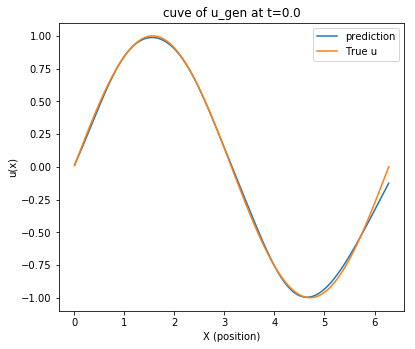

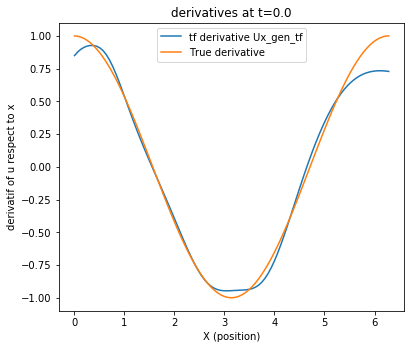

------------------------------------------------------------
t=3.1098593944626236


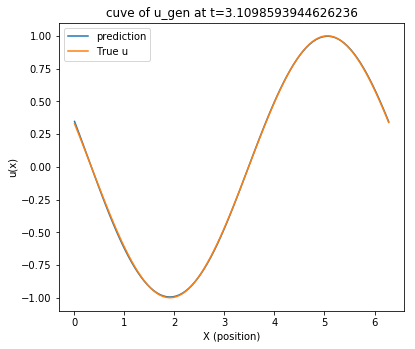

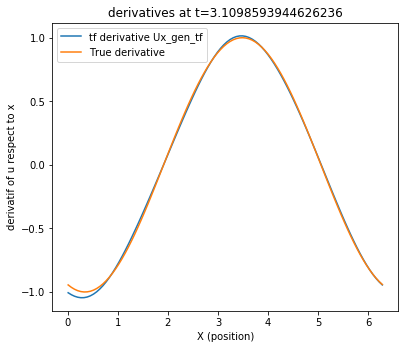

------------------------------------------------------------
t=6.283185307179586


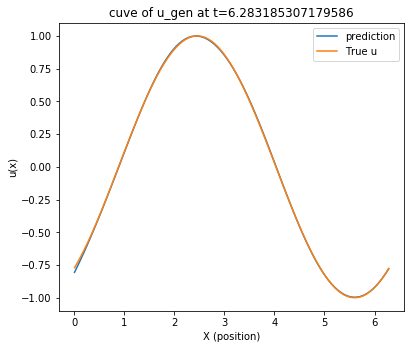

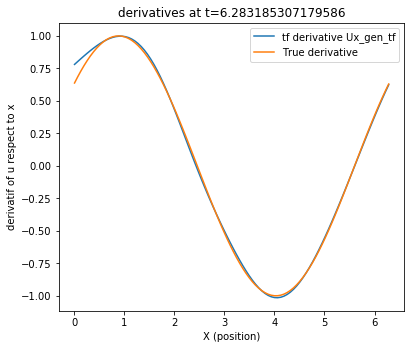

In [ ]:

listT=[0, int((nb_x_t/2)-1),nb_x_t-1]
for t in listT:
  print("------------------------------------------------------------")
  print('t='+str(T_gen[t]))
  fig=plt.figure(figsize=(6,5))
  axes= fig.add_axes([0.1,0.1,0.8,0.8])
  X_gen_test=np.array(list(product(X_gen,[T_gen[t]])))
  axes.plot(X_gen, model.predict(X_gen_test))
  axes.plot(X_gen,U_gen[t])
  plt.legend(["prediction", "True u"])
  plt.title('cuve of u_gen at t='+str(T_gen[t]))
  plt.xlabel('X (position)')
  plt.ylabel('u(x)')
  plt.show()

  fig=plt.figure(figsize=(6,5))
  axes= fig.add_axes([0.1,0.1,0.8,0.8])
  X_gen_test=np.array(list(product(X_gen,[T_gen[t]])))
  axes.plot(X_gen, Ux_gen_tf[t])
  axes.plot(X_gen,Ux_gen[t])
  liste_legendes=["tf derivative Ux_gen_tf","True derivative"]
  plt.legend(liste_legendes)
  plt.title('derivatives at t='+str(T_gen[t]))
  plt.xlabel('X (position)')
  plt.ylabel('derivatif of u respect to x')
  plt.show()

###Test of generated x and t (test set) and derivative respect to t:

$x \approx 0$  , $x \approx \pi$,      $x \approx 2 \pi$

------------------------------------------------------------
x=0.01


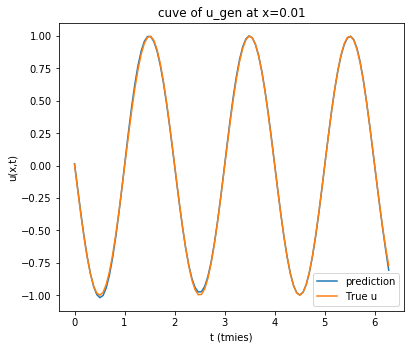

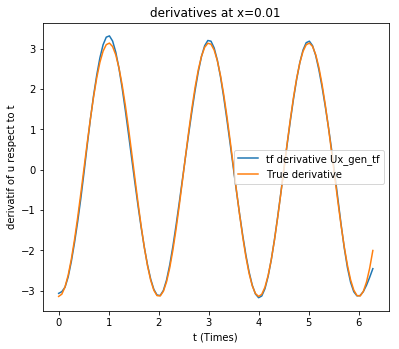

------------------------------------------------------------
x=3.1149098995131284


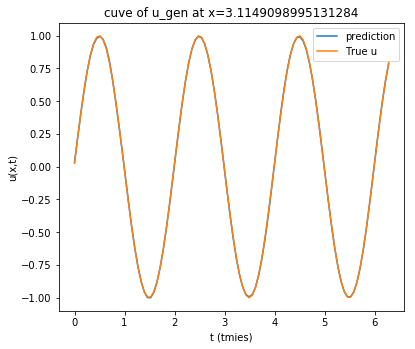

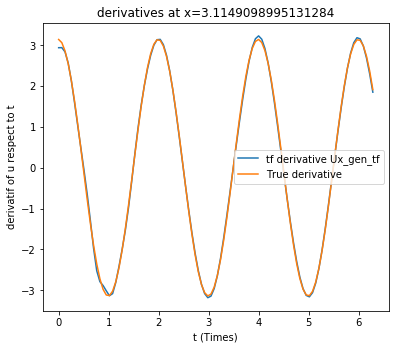

------------------------------------------------------------
x=6.283185307179586


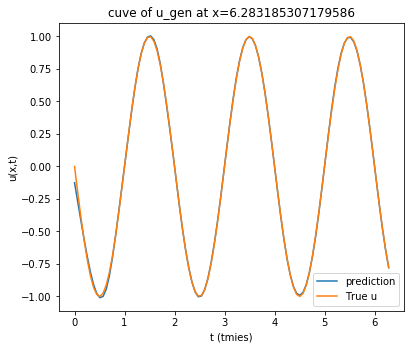

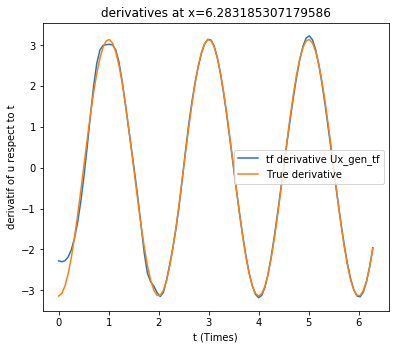

In [ ]:

listX=[0, int((nb_x_t/2)-1),nb_x_t-1]
for x in listX:
  print("------------------------------------------------------------")
  print('x='+str(X_gen[x]))
  fig=plt.figure(figsize=(6,5))
  axes= fig.add_axes([0.1,0.1,0.8,0.8])
  X_gen_test=np.array(list(product([X_gen[x]],T_gen)))
  axes.plot(T_gen, model.predict(X_gen_test))
  axes.plot(T_gen,U_gen[:,x])
  plt.legend(["prediction", "True u"])
  plt.title('cuve of u_gen at x='+str(X_gen[x]))
  plt.xlabel('t (tmies)')
  plt.ylabel('u(x,t)')
  plt.show()
  
  fig=plt.figure(figsize=(6,5))
  axes= fig.add_axes([0.1,0.1,0.8,0.8])
  axes.plot(T_gen, Ut_gen_tf[:,x])
  axes.plot(T_gen,Ut_gen[:,x])
  liste_legendes=["tf derivative Ux_gen_tf","True derivative"]
  plt.legend(liste_legendes)
  plt.title('derivatives at x='+str(X_gen[x]))
  plt.xlabel('t (Times)')
  plt.ylabel('derivatif of u respect to t')
  plt.show()